# How to use this notebook
This notebook is meant to accompany an article published in "Linux Magazin" XXXXX (german). The code snippets directly refer to the article are probably not self-explanatory.

### _Vorbereitungen_
Imports der benötigten Bibliotheken, API einrichten

In [1]:
from qiskit import QuantumCircuit, execute,  Aer, QuantumRegister, IBMQ
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_aqt_provider import AQTProvider
from qiskit.visualization import plot_histogram
from qiskit.utils.mitigation  import *
from qiskit.compiler import transpile, assemble

In [2]:
from qiskit.providers.ibmq import least_busy

IBMQ_API_TOKEN = "PUT_YOUR_IBMQ_TOKEN_HERE"
AQT_TOKEN = 'MY_AQT_TOKEN'
IBMQ.enable_account(IBMQ_API_TOKEN)
provider = IBMQ.get_provider()
device = least_busy(provider.backends(simulator=False)) #change to True to run on simulators

### 4. Erste Schritte / Praxisbeispiele

In [3]:
simulator = Aer.get_backend('qasm_simulator')

qc1 = QuantumCircuit(3)
qc1.h(0)
qc1.cx(0, 1)
qc1.cx(0, 2)
qc1.measure_all()

# Schaltkreis mit Aer simulieren
job = execute(qc1, simulator, shots=4000)
result = job.result()
counts=result.get_counts()
print(counts)

{'000': 2023, '111': 1977}


In [4]:
# Schaltkreis auf Quantencomputer laufen lassen

job = execute(qc1, backend = device, shots=4000)
result = job.result()
counts=result.get_counts()
print(counts)

{'000': 2003, '111': 1997}


#### Lokales Beispiel mit Qiskit Runtime

In [5]:
N = 5
qc2 = QuantumCircuit(N)
qc2.h(0)
for x in range(1, N):
  qc2.cx(0,x)
#qc2 += QFT(num_qubits=N)
qc2.compose(QFT(num_qubits=N), inplace=True)
qc2.measure_all()
program_inputs = {
    "circuits": qc2,
    "circuit_indices": [0],
}
service = QiskitRuntimeService()
options = {'backend_name': "ibmq_qasm_simulator"}
job = service.run(
    program_id="sampler",
    options=options,
    inputs=program_inputs,
)

#Dieser Teil ist blockierend. Man wartet auf das Ergebnis.
print(job.result())

{'quasi_dists': [{'01110': 0.001953125, '10011': 0.0078125, '11010': 0.0390625, '11001': 0.033203125, '00111': 0.033203125, '01100': 0.0146484375, '00010': 0.0556640625, '11100': 0.0478515625, '11110': 0.056640625, '00110': 0.0517578125, '00011': 0.05078125, '00100': 0.0615234375, '11011': 0.0498046875, '01000': 0.037109375, '01101': 0.001953125, '00001': 0.07421875, '10010': 0.001953125, '10110': 0.0234375, '11111': 0.0546875, '10100': 0.0107421875, '11101': 0.052734375, '11000': 0.025390625, '10111': 0.0244140625, '01010': 0.017578125, '10101': 0.015625, '01011': 0.0166015625, '00000': 0.0732421875, '01001': 0.0244140625, '00101': 0.0419921875}], 'metadata': [{'header_metadata': {'circuit_digest': '9b6ce8fe003c09467ca2f2f1673c77aed4de1ffd043ebd71d3aea51fbb493bb3'}, 'shots': 1024}]}


#### AQT

In [6]:
aqt = AQTProvider(AQT_TOKEN)
print(aqt.backends())
sim_backend = aqt.backends.aqt_qasm_simulator

[<AQTSimulator('aqt_qasm_simulator')>, <AQTSimulatorNoise1('aqt_qasm_simulator_noise_1')>, <AQTDevice('aqt_innsbruck')>]


### Error Mitigation

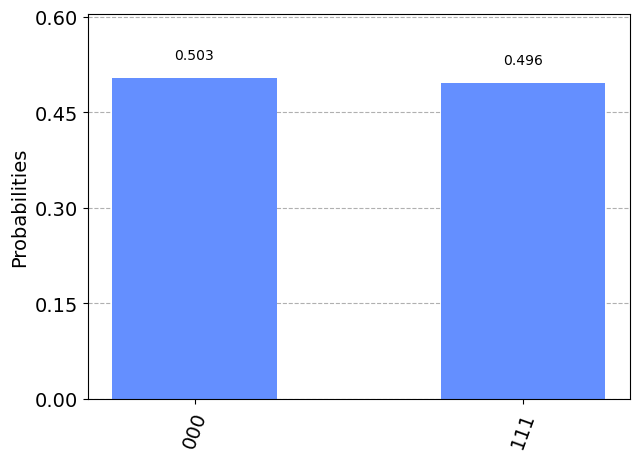

In [7]:
# Schaltkreis mit Aer simulieren

counts = execute(qc1, simulator, shots=10000).result().get_counts()
plot_histogram(counts)

{'000': 4983, '111': 5017}


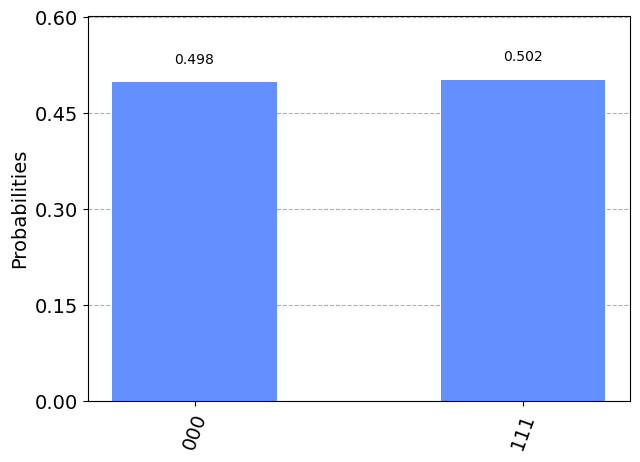

In [8]:
# Schaltkreis auf Quantencomputer laufen lassen

#device = provider.get_backend('ibmq_belem')
results = execute(qc1, device, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

# Beispielhaftes Ergebnis: {'000': 4973, '001': 70, '010': 145, '011': 334, '100': 55, '101': 254, '110': 173, '111': 3996}

plot_histogram(noisy_counts)

In [9]:
# Durchlaufe alle acht Basiszustände

qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_000
        ░ ┌─┐      
q32_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q32_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q32_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c0: 3/════╩══╩══╩═
           0  1  2 

Circuit mcalcal_001
       ┌───┐ ░ ┌─┐      
q32_0: ┤ X ├─░─┤M├──────
       └───┘ ░ └╥┘┌─┐   
q32_1: ──────░──╫─┤M├───
             ░  ║ └╥┘┌─┐
q32_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c0: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_010
             ░ ┌─┐      
q32_0: ──────░─┤M├──────
       ┌───┐ ░ └╥┘┌─┐   
q32_1: ┤ X ├─░──╫─┤M├───
       └───┘ ░  ║ └╥┘┌─┐
q32_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c0: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_011
       ┌───┐ ░ ┌─┐      
q32_0: ┤ X ├─░─┤M├──────
       ├───┤ ░ └╥┘┌─┐   
q32_1: ┤ X ├─░──╫─┤M├───
       └───┘ ░  ║ └╥┘┌─┐
q32_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c0: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_100
             ░ ┌─┐      
q32_0: ──────░─┤

In [10]:
# Berechne Korrekturmatrix

t_qc = transpile(meas_calibs, device)
qobj = assemble(t_qc, shots=10000)
cal_results = device.run(qobj, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

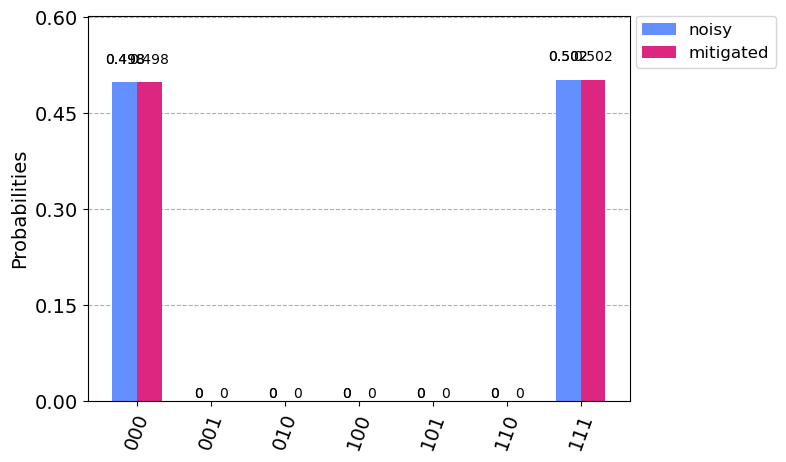

In [11]:
# Filter Objekt erstellen
meas_filter = meas_fitter.filter

# Neue Ergebnisse nach Mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [12]:
# Berechnung der Quasi-Probabilities mit IBMQ-QASM-Simulator

service = QiskitRuntimeService()

with Sampler(circuits=[qc1], service=service, options={ "backend": "ibmq_qasm_simulator" }) as sampler:
    result = sampler(circuits=[0], shots=10000)
    print(result)

SamplerResult(quasi_dists=[{'000': 0.4964, '111': 0.5036}], metadata=[{'header_metadata': {'circuit_digest': 'e571fba44e9b117ebdec413e620d70b9f08dd401f3f8f9ed1dfd9082bb097cf4'}, 'shots': 10000}])


In [13]:
import qiskit.tools.jupyter
%qiskit_version_table